# Question_3:  

### Do the category/type of goods have a significant impact on the quantity ordered?

$H_0:$ There is no differnce in the category, or types, of goods sold and the sales


$H_A:$ There is a difference between the category of goods and the amount of goods sold.

For our initial hypothesis test, we are testing to see if there is a sigificant impact on on sales by the types of good.  

The idea being that certain goods, such as grain or animal products, may have a significant impact on sales compared to their other counterparts.


### Import packages:

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import custom_tools as ct
import MyConn as mc
import scipy.stats as scs
import flatiorn_stats as fs
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from statsmodels.stats.power import tt_ind_solve_power, tt_solve_power
import statsmodels.api as sm
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
myconn = mc.MyConn(filename='Northwind_small.sqlite')

myconn.database_tables()

Connection established


['Employee',
 'Category',
 'Customer',
 'Shipper',
 'Supplier',
 'Order',
 'Product',
 'OrderDetail',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Region',
 'Territory',
 'EmployeeTerritory']

In [3]:
myconn.list_table_columns(table_name='OrderDetail')

[(0, 'Id', 'VARCHAR(8000)', 0, None, 1),
 (1, 'OrderId', 'INTEGER', 1, None, 0),
 (2, 'ProductId', 'INTEGER', 1, None, 0),
 (3, 'UnitPrice', 'DECIMAL', 1, None, 0),
 (4, 'Quantity', 'INTEGER', 1, None, 0),
 (5, 'Discount', 'DOUBLE', 1, None, 0)]

In [4]:
myconn.list_table_columns(table_name='[Order]')

[(0, 'Id', 'INTEGER', 0, None, 1),
 (1, 'CustomerId', 'VARCHAR(8000)', 0, None, 0),
 (2, 'EmployeeId', 'INTEGER', 1, None, 0),
 (3, 'OrderDate', 'VARCHAR(8000)', 0, None, 0),
 (4, 'RequiredDate', 'VARCHAR(8000)', 0, None, 0),
 (5, 'ShippedDate', 'VARCHAR(8000)', 0, None, 0),
 (6, 'ShipVia', 'INTEGER', 0, None, 0),
 (7, 'Freight', 'DECIMAL', 1, None, 0),
 (8, 'ShipName', 'VARCHAR(8000)', 0, None, 0),
 (9, 'ShipAddress', 'VARCHAR(8000)', 0, None, 0),
 (10, 'ShipCity', 'VARCHAR(8000)', 0, None, 0),
 (11, 'ShipRegion', 'VARCHAR(8000)', 0, None, 0),
 (12, 'ShipPostalCode', 'VARCHAR(8000)', 0, None, 0),
 (13, 'ShipCountry', 'VARCHAR(8000)', 0, None, 0)]

In [5]:
myconn.list_table_columns(table_name='[Product]')

[(0, 'Id', 'INTEGER', 0, None, 1),
 (1, 'ProductName', 'VARCHAR(8000)', 0, None, 0),
 (2, 'SupplierId', 'INTEGER', 1, None, 0),
 (3, 'CategoryId', 'INTEGER', 1, None, 0),
 (4, 'QuantityPerUnit', 'VARCHAR(8000)', 0, None, 0),
 (5, 'UnitPrice', 'DECIMAL', 1, None, 0),
 (6, 'UnitsInStock', 'INTEGER', 1, None, 0),
 (7, 'UnitsOnOrder', 'INTEGER', 1, None, 0),
 (8, 'ReorderLevel', 'INTEGER', 1, None, 0),
 (9, 'Discontinued', 'INTEGER', 1, None, 0)]

In [6]:
myconn.list_table_columns(table_name='[Category]')

[(0, 'Id', 'INTEGER', 0, None, 1),
 (1, 'CategoryName', 'VARCHAR(8000)', 0, None, 0),
 (2, 'Description', 'VARCHAR(8000)', 0, None, 0)]

In our database, we have 8 different categories of produce that are sold by the Northwind Corporation, listed below.

In [7]:
myconn.select_all_from_table(table_name='[Category]', load_df=True)

,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"
5,6,Meat/Poultry,Prepared meats
6,7,Produce,Dried fruit and bean curd
7,8,Seafood,Seaweed and fish


First, we create our query to pull the necessary information out of the Northwinds Database.

In [8]:
query = """
    SELECT o.ID as order_id, p.ProductName, od.Discount, od.Quantity, cat.CategoryName, 
            cust.City, cust.Country, cust.Region
    FROM [Order] as o
    JOIN Customer as cust
        ON o.CustomerId = cust.Id
    JOIN OrderDetail as od
        ON order_id =  od.orderId
    JOIN Product as p
        ON od.ProductId = p.Id
    JOIN Category as cat
        ON p.CategoryId = cat.Id;
"""
df = myconn.run_query(query, load_df=True)

In [9]:
df.head()

,order_id,ProductName,Discount,Quantity,CategoryName,City,Country,Region
0,10248,Queso Cabrales,0.0,12,Dairy Products,Reims,France,Western Europe
1,10248,Singaporean Hokkien Fried Mee,0.0,10,Grains/Cereals,Reims,France,Western Europe
2,10248,Mozzarella di Giovanni,0.0,5,Dairy Products,Reims,France,Western Europe
3,10249,Tofu,0.0,9,Produce,Münster,Germany,Western Europe
4,10249,Manjimup Dried Apples,0.0,40,Produce,Münster,Germany,Western Europe


In the following cells, box plots of the amount of goods sold by category have been made, so as to see how the quantity of different goods bought compare to one another.  Based on the following data, each of the differnet categories have approximately the same average amount sold.  The `Meat/Poultry` category is noticeably, but slightly lower than the other goods ordered. 

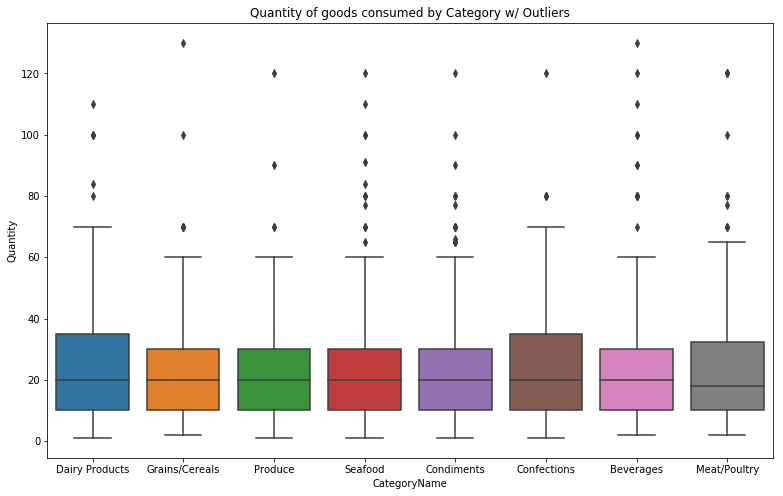

Quantity                                                     
                  count       mean        std  min   25%   50%    75%    max
CategoryName                                                                
Beverages         389.0  23.421594  19.331672  2.0  10.0  20.0  30.00  130.0
Condiments        209.0  24.712919  19.977003  1.0  10.0  20.0  30.00  120.0
Confections       321.0  23.800623  17.472768  1.0  10.0  20.0  35.00  120.0
Dairy Products    350.0  25.017143  18.831777  1.0  10.0  20.0  35.00  110.0
Grains/Cereals    190.0  23.452632  18.181198  2.0  10.0  20.0  30.00  130.0
Meat/Poultry      168.0  24.434524  22.532117  2.0  10.0  18.0  32.25  120.0
Produce           132.0  22.136364  18.575110  1.0  10.0  20.0  30.00  120.0
Seafood           319.0  23.699060  19.318671  1.0  10.0  20.0  30.00  120.0

In [10]:
plt.figure(figsize=(13,8))

sns.boxplot(x='CategoryName', y='Quantity', data=df)
plt.title('Quantity of goods consumed by Category w/ Outliers')
plt.show()

df.drop(['order_id','Discount'], axis=1).groupby(['CategoryName']).describe()

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


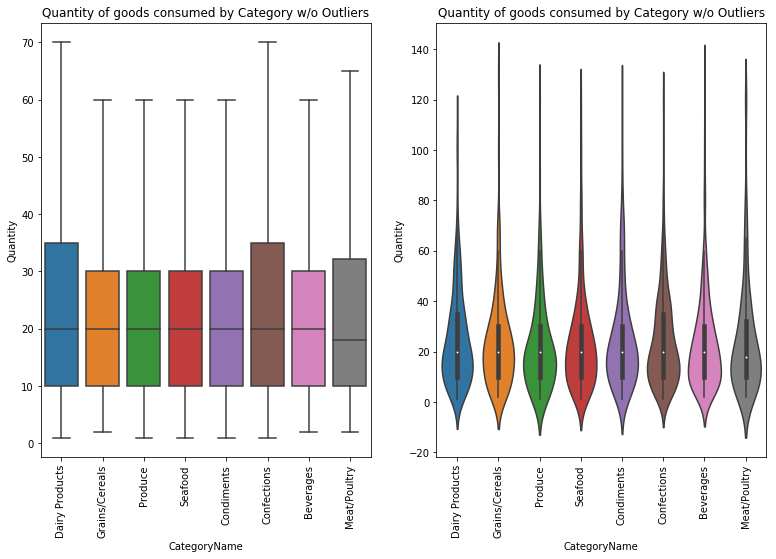

In [11]:
## Remove outliers from our boxplot to better view patterns accross different Categories ##
# plt.figure(figsize=(13,8))

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(13,8))

sns.boxplot(x='CategoryName', y='Quantity', data=df, ax=ax1, showfliers=False)
ax1.set_title('Quantity of goods consumed by Category w/o Outliers')
ax1.tick_params(axis='x', labelrotation=90)

sns.violinplot(x='CategoryName', y='Quantity', data=df, ax=ax2, showfliers=False)
ax2.set_title('Quantity of goods consumed by Category w/o Outliers')
ax2.tick_params(axis='x', labelrotation=90)

plt.show()

Based on the boxplots, the mean of the goods ordered are all almost identical, with the exception of Meat/Poultry goods, which are noticeably lower than the other categores ordered.

In this section, we are comparing the category of goods sold by order region, to see wether what patterns arise.

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


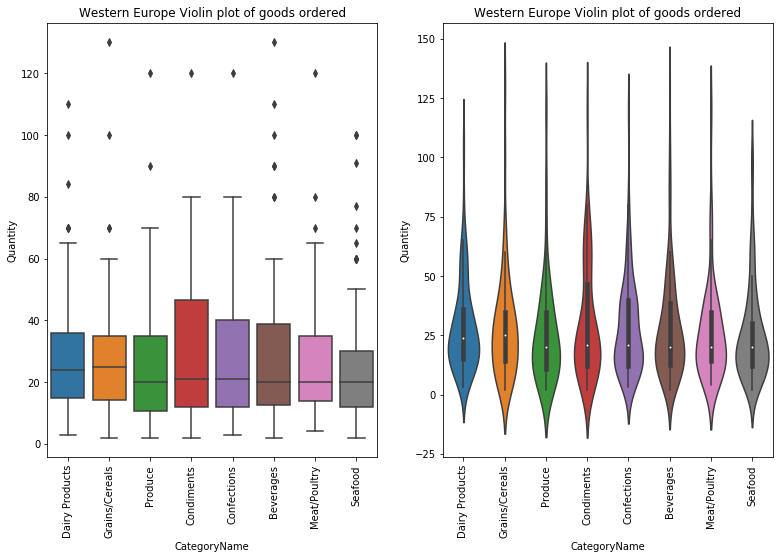

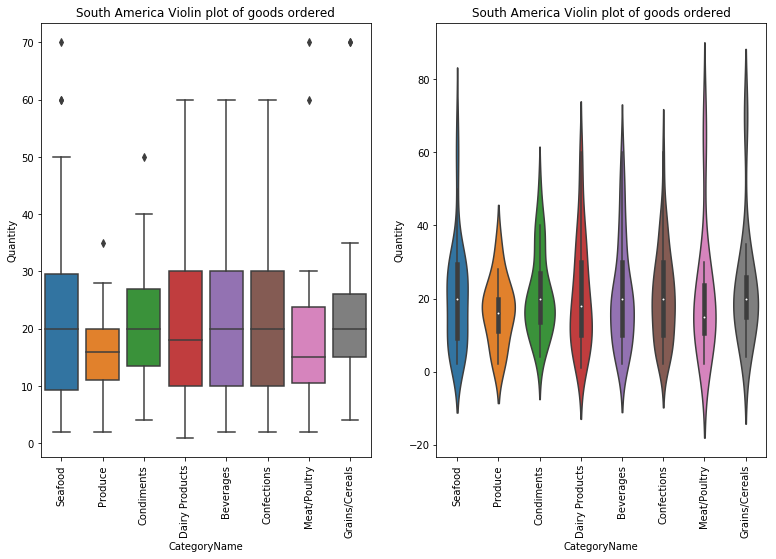

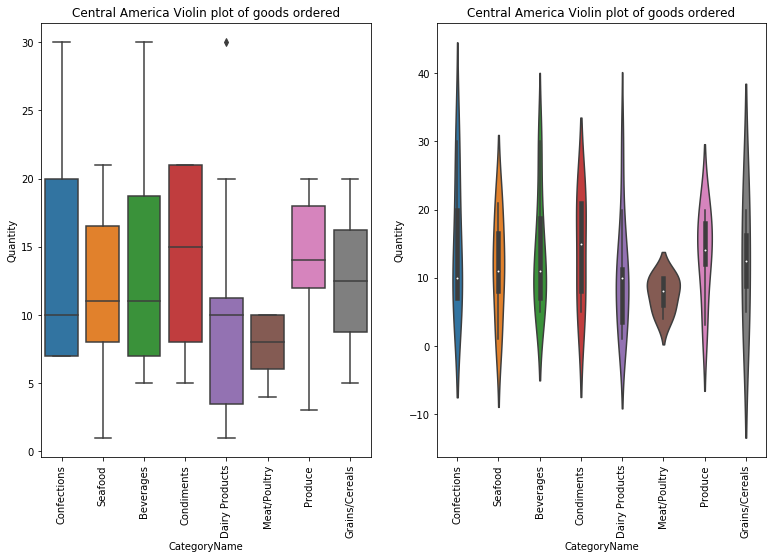

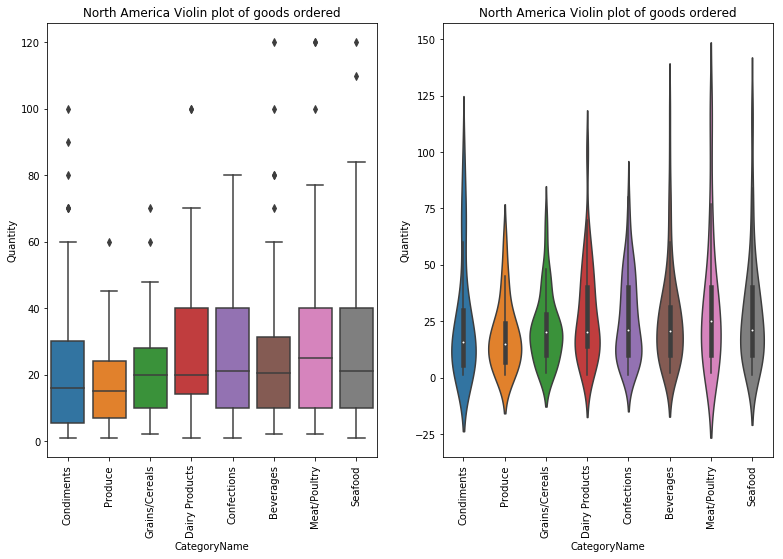

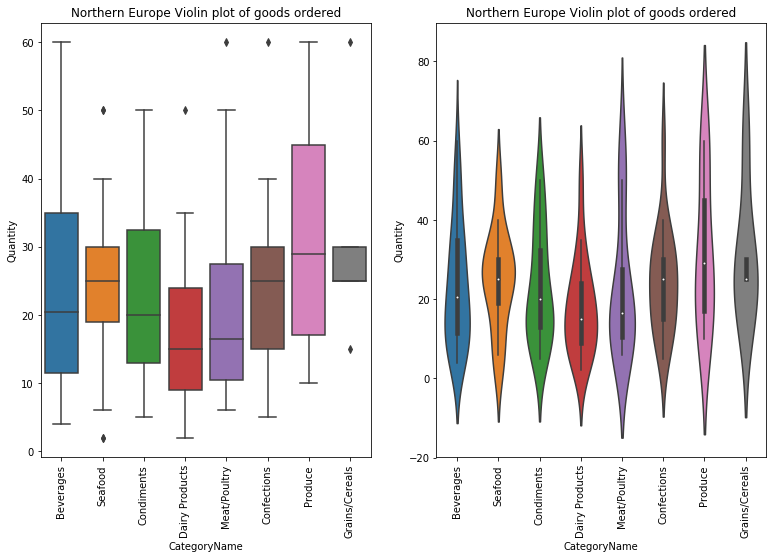

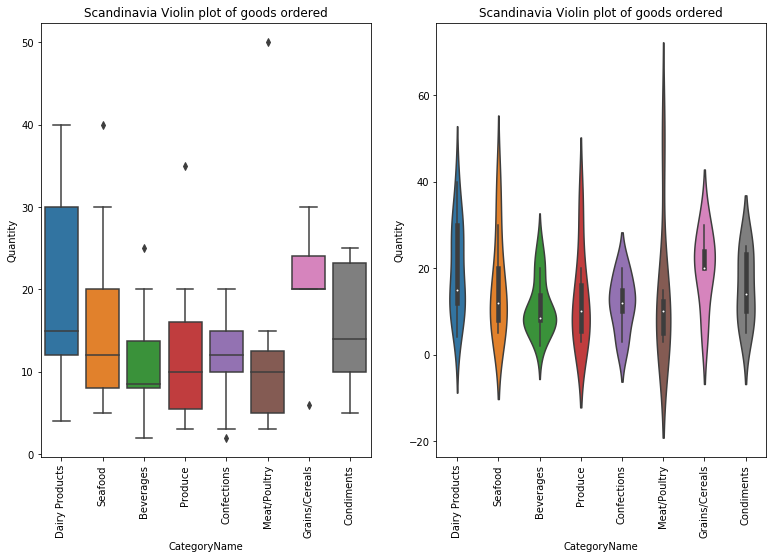

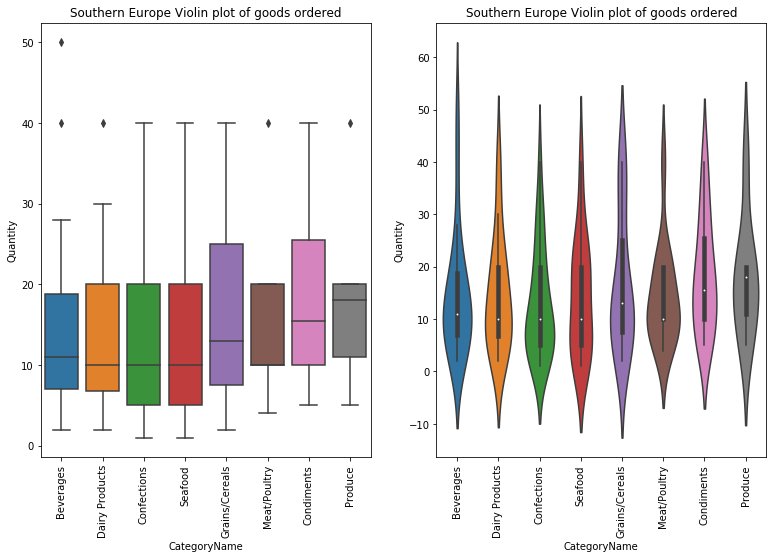

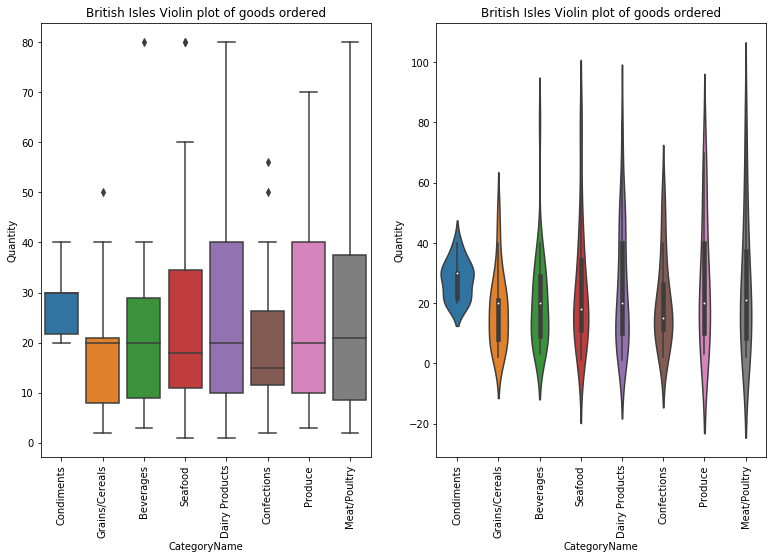

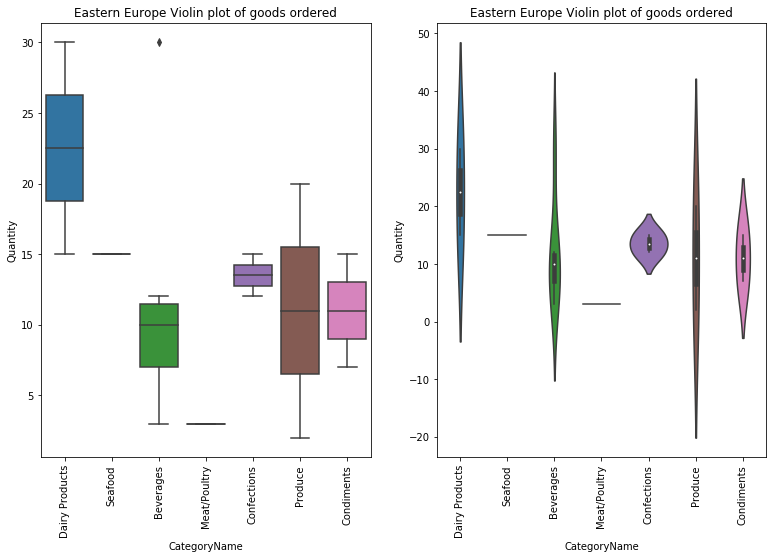

In [12]:
# for cat in df.CategoryName.unique():
#     plt.figure(figsize=(8,5))
#     sns.violinplot(x='Region', y='Quantity', data=df[df.CategoryName==cat], )
#     plt.title(f'{cat} Boxplot of goods ordered')
#     plt.xticks(rotation=90)
#     plt.show()

for region in df.Region.unique():

    fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(13,8))

    sns.boxplot(x='CategoryName', y='Quantity', data=df[df.Region==region], ax=ax1, showfliers=True)
    ax1.set_title(f'{region} Violin plot of goods ordered')
    ax1.tick_params(axis='x', labelrotation=90)
    
    sns.violinplot(x='CategoryName', y='Quantity', data=df[df.Region==region], ax=ax2, showfliers=False)
    ax2.set_title(f'{region} Violin plot of goods ordered')
    ax2.tick_params(axis='x', labelrotation=90)
    
    plt.show()

After looking at the various plots for our data, we can estimate that our data is **not** normal.  To remedy this issue, we will take bootstrap samples. We will also plot out the histograms for our data and run normality tests to verify that this is indeed the case.

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


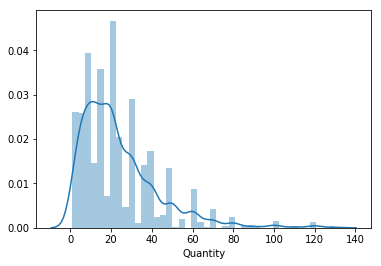

In [13]:
# df.hist(column='Quantity', density=True)
sns.distplot(a=df.Quantity)

Is our data normal?

In [14]:
print('Total Category goods quantity:')
ct.normality_test_shapiro(df.Quantity)
print('\n')

categories = df.CategoryName.unique()
for cat in categories:
    print(cat)
    ct.normality_test_shapiro(df[df.CategoryName==cat].Quantity)
    print('\n')

Total Category goods quantity:
p = 1.5829487842552431e-40
Therefore the data is NOT normal


Dairy Products
p = 3.185873450223557e-15
Therefore the data is NOT normal


Grains/Cereals
p = 5.496201367291564e-13
Therefore the data is NOT normal


Produce
p = 5.014441639694667e-11
Therefore the data is NOT normal


Seafood
p = 1.703039811538066e-17
Therefore the data is NOT normal


Condiments
p = 1.200306672631546e-13
Therefore the data is NOT normal


Confections
p = 6.385523891334205e-14
Therefore the data is NOT normal


Beverages
p = 1.853825005389421e-20
Therefore the data is NOT normal


Meat/Poultry
p = 3.23095127312701e-14
Therefore the data is NOT normal




array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022EEBDD8DD8>,
      dtype=object)

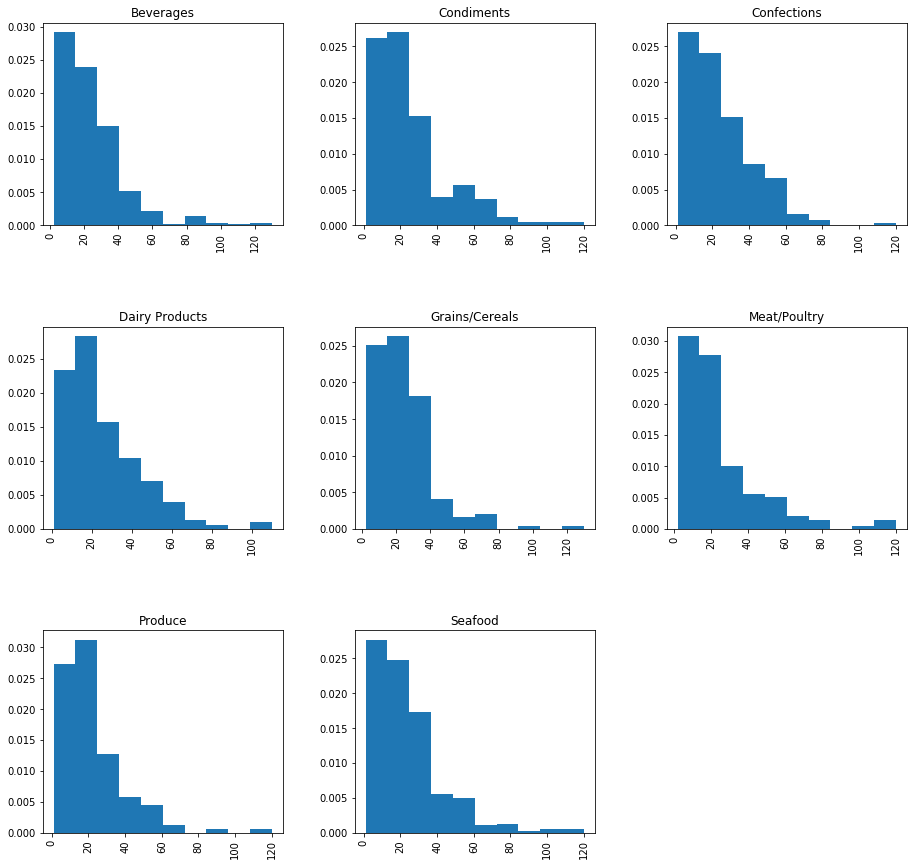

In [15]:
df.hist(column='Quantity', by=['CategoryName'], figsize=[15,15], density=True)

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


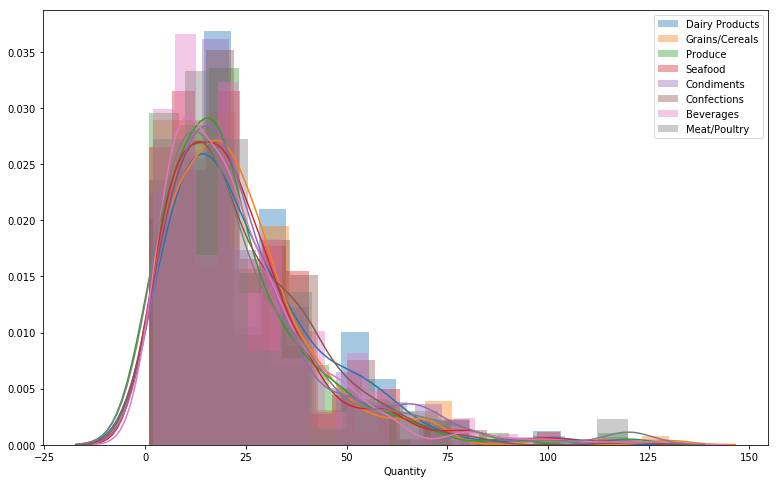

In [16]:
plt.figure(figsize=(13,8))

categories = df.CategoryName.unique()
for cat in categories:
    sns.distplot(a=df[df.CategoryName==cat].Quantity, label=cat)
    plt.legend()
plt.show()

Based on the histograms, our shapiro normality test, as well as the distributions that are present, **the data is not normal**.  Since this is the case, we will take random samples from our respective categories to further test our hypothesis.

### Sampling

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


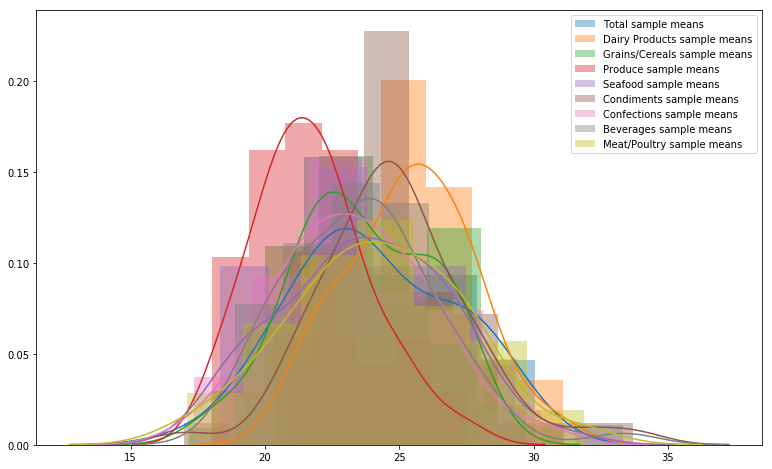

In [17]:
plt.figure(figsize=(13,8))

n = sample_size = 50 #set the number of samples equal to the size of each sample to simplify arguments passed in
dict_samp_means = {}
categories = df.CategoryName.unique()

sample_a = ct.bootstrap_sampling(n=n, pop=df.Quantity, samp_size=sample_size, replace=True)
sns.distplot(a=sample_a, label='Total sample means')

dict_samp_means['pop_samp_means'] = sample_a
for cat in categories:

    sample_b = ct.bootstrap_sampling(n=n, pop=df[df.CategoryName==cat].Quantity, samp_size=sample_size, replace=True)
    dict_samp_means[cat.replace(" ", "_").replace('/','_')] = sample_b
    
    sns.distplot(a=sample_b, label=f'{cat} sample means')
    
plt.legend()
plt.show()

In [18]:
df_samp_means = pd.DataFrame.from_dict(dict_samp_means)

### ANOVA Testing

In [19]:
alpha = 0.05

# ANOVA Test on region
formula = f'pop_samp_means ~ Dairy_Products + Meat_Poultry + Grains_Cereals + Beverages + Confections + Produce + Seafood + Condiments'
lm = ols(formula, dict_samp_means).fit()
table = sm.stats.anova_lm(lm, typ=2)
table['reject_null'] = table['PR(>F)'] < alpha
df_table = pd.DataFrame(table)

df_table

,sum_sq,df,F,PR(>F),reject_null
Dairy_Products,0.011858,1.0,0.001151,0.973103,False
Meat_Poultry,9.088089,1.0,0.881941,0.353171,False
Grains_Cereals,0.011751,1.0,0.001140,0.973225,False
Beverages,0.035446,1.0,0.003440,0.953516,False
Confections,2.142664,1.0,0.207932,0.650800,False
Produce,3.918403,1.0,0.380256,0.540876,False
Seafood,7.351560,1.0,0.713422,0.403212,False
Condiments,3.770861,1.0,0.365938,0.548560,False
Residual,422.490504,41.0,NaN,NaN,False


Based on our ANOVA test, we fail to reject our null hypothesis with an $\alpha=0.05$ and based on this information, there is no difference in variance for our different categories.

We will now run our tukey test to verify if this is truly the case

### Tukey Test

In [20]:
## Stack the data for the tukey test ##
stacked_data = df_samp_means.stack().reset_index()
stacked_data = stacked_data.rename(columns={'level_0': 'id',
                                            'level_1': 'category',
                                            0:'quantity'})

      Multiple Comparison of Means - Tukey HSD,FWER=0.05     
    group1         group2     meandiff  lower   upper  reject
-------------------------------------------------------------
  Beverages      Condiments    1.1484  -0.5098  2.8066 False 
  Beverages     Confections   -0.3136  -1.9718  1.3446 False 
  Beverages    Dairy_Products  1.7472   0.089   3.4054  True 
  Beverages    Grains_Cereals -0.0268   -1.685  1.6314 False 
  Beverages     Meat_Poultry   0.5412   -1.117  2.1994 False 
  Beverages       Produce     -1.8884  -3.5466 -0.2302  True 
  Beverages       Seafood      0.0884  -1.5698  1.7466 False 
  Condiments    Confections    -1.462  -3.1202  0.1962 False 
  Condiments   Dairy_Products  0.5988  -1.0594  2.257  False 
  Condiments   Grains_Cereals -1.1752  -2.8334  0.483  False 
  Condiments    Meat_Poultry  -0.6072  -2.2654  1.051  False 
  Condiments      Produce     -3.0368   -4.695 -1.3786  True 
  Condiments      Seafood      -1.06   -2.7182  0.5982 False 
 Confect

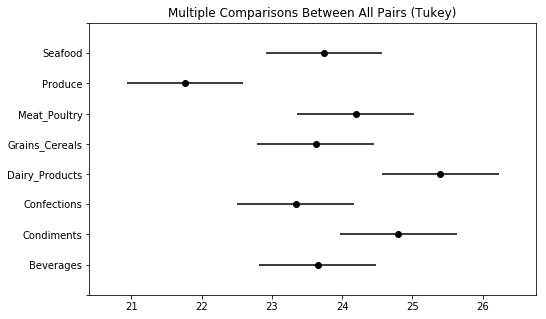

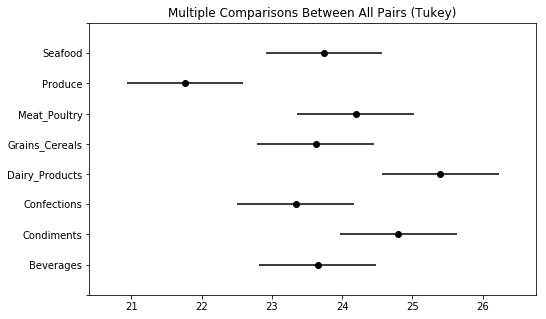

In [21]:
## Tukey Test on Categories of food ##

# Set up the data for comparison (creates a specialised object)
MultiComp = MultiComparison(data=stacked_data[stacked_data.category != 'pop_samp_means'].quantity,
                            groups=stacked_data[stacked_data.category != 'pop_samp_means'].category)
results = MultiComp.tukeyhsd()
# Show all pair-wise comparisons:
# Print the comparisons
print(results.summary())
results.plot_simultaneous(figsize=(8,5))

### Effect size & power calcualtion against population samples


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


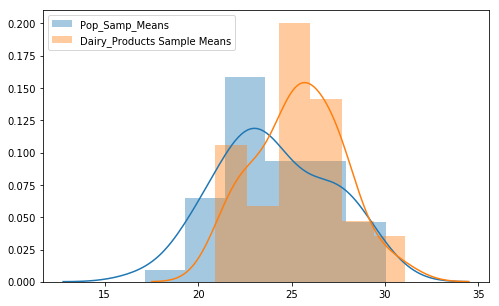

Shapiro Normality Test Test For Pop_Samp_Means
p = 0.6721957921981812
Therefore the data is normal

Shapiro Normality Test Test For Dairy_Products
p = 0.6721957921981812
Therefore the data is normal

Levene variance test of pop_samp_means and Dairy_Products
p = 0.0678413546112536
Therefore the data HAS equal variances

Welch T-Test of our data:
2.454424511289352

p-value of Welch TTest
0.01598717692071805

Independent ttest scipy.stats
Ttest_indResult(statistic=-2.454424511289352, pvalue=0.015874766647935384)

Cohen_D Of Pop_Samp_Means And Dairy_Products
0.49586863309805107

Statistical Power of the discount given alpha=0.05, effect size:0.49586863309805107, nobs1:50
0.6897123977911597


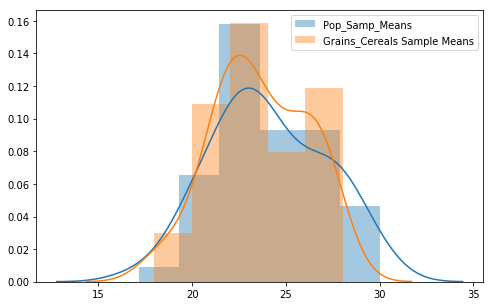

Shapiro Normality Test Test For Pop_Samp_Means
p = 0.20212338864803314
Therefore the data is normal

Shapiro Normality Test Test For Grains_Cereals
p = 0.20212338864803314
Therefore the data is normal

Levene variance test of pop_samp_means and Grains_Cereals
p = 0.2508789573888041
Therefore the data HAS equal variances

Welch T-Test of our data:
0.808860983686444

p-value of Welch TTest
0.4206202005450299

Independent ttest scipy.stats
Ttest_indResult(statistic=0.808860983686444, pvalue=0.42055447911049726)

Cohen_D Of Pop_Samp_Means And Grains_Cereals
0.16341459617197313

Statistical Power of the discount given alpha=0.05, effect size:0.16341459617197313, nobs1:50
0.12770256281019077


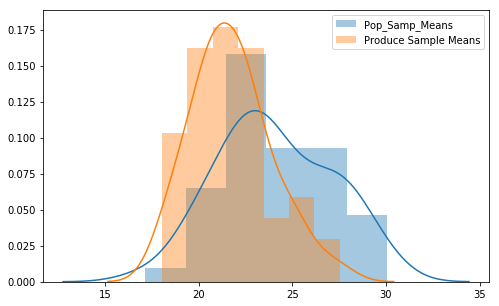

Shapiro Normality Test Test For Pop_Samp_Means
p = 0.379171758890152
Therefore the data is normal

Shapiro Normality Test Test For Produce
p = 0.379171758890152
Therefore the data is normal

Levene variance test of pop_samp_means and Produce
p = 0.01414508551467019
Therefore the data DOES NOT have equal variances

Welch T-Test of our data:
4.424488240261005

p-value of Welch TTest
2.756922589308708e-05

Independent ttest scipy.stats
Ttest_indResult(statistic=4.424488240261005, pvalue=2.756922589305997e-05)

Cohen_D Of Pop_Samp_Means And Produce
0.8938816108481976

Statistical Power of the discount given alpha=0.05, effect size:0.8938816108481976, nobs1:50
0.9931540393257208


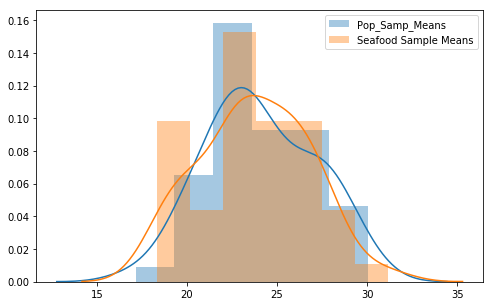

Shapiro Normality Test Test For Pop_Samp_Means
p = 0.5325281023979187
Therefore the data is normal

Shapiro Normality Test Test For Seafood
p = 0.5325281023979187
Therefore the data is normal

Levene variance test of pop_samp_means and Seafood
p = 0.9855761961172093
Therefore the data HAS equal variances

Welch T-Test of our data:
0.5525256667346757

p-value of Welch TTest
0.5818462917614307

Independent ttest scipy.stats
Ttest_indResult(statistic=0.5525256667346757, pvalue=0.5818462912579812)

Cohen_D Of Pop_Samp_Means And Seafood
0.11162704163648789

Statistical Power of the discount given alpha=0.05, effect size:0.11162704163648789, nobs1:50
0.08566362314103698


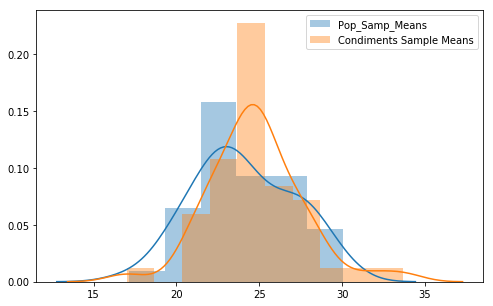

Shapiro Normality Test Test For Pop_Samp_Means
p = 0.1454511284828186
Therefore the data is normal

Shapiro Normality Test Test For Condiments
p = 0.1454511284828186
Therefore the data is normal

Levene variance test of pop_samp_means and Condiments
p = 0.28832890951842866
Therefore the data HAS equal variances

Welch T-Test of our data:
1.2356706973839622

p-value of Welch TTest
0.2195435187128414

Independent ttest scipy.stats
Ttest_indResult(statistic=-1.2356706973839622, pvalue=0.21953486299101516)

Cohen_D Of Pop_Samp_Means And Condiments
0.24964317983820286

Statistical Power of the discount given alpha=0.05, effect size:0.24964317983820286, nobs1:50
0.23524129150588455


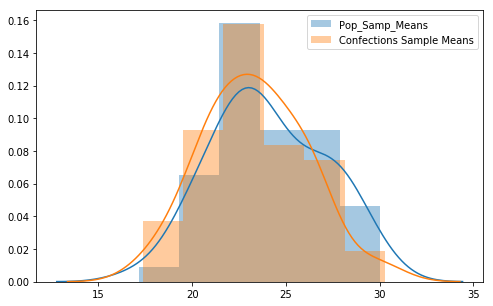

Shapiro Normality Test Test For Pop_Samp_Means
p = 0.9301057457923889
Therefore the data is normal

Shapiro Normality Test Test For Confections
p = 0.9301057457923889
Therefore the data is normal

Levene variance test of pop_samp_means and Confections
p = 0.47783509742134156
Therefore the data HAS equal variances

Welch T-Test of our data:
1.272053154670465

p-value of Welch TTest
0.20638845304307196

Independent ttest scipy.stats
Ttest_indResult(statistic=1.272053154670465, pvalue=0.2063644446017576)

Cohen_D Of Pop_Samp_Means And Confections
0.25699354619920745

Statistical Power of the discount given alpha=0.05, effect size:0.25699354619920745, nobs1:50
0.24647522233026264


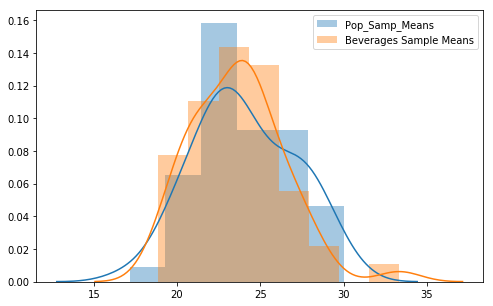

Shapiro Normality Test Test For Pop_Samp_Means
p = 0.07451505959033966
Therefore the data is normal

Shapiro Normality Test Test For Beverages
p = 0.07451505959033966
Therefore the data is normal

Levene variance test of pop_samp_means and Beverages
p = 0.40855654942955755
Therefore the data HAS equal variances

Welch T-Test of our data:
0.7239986446141734

p-value of Welch TTest
0.4708003606742701

Independent ttest scipy.stats
Ttest_indResult(statistic=0.7239986446141736, pvalue=0.47079135893926083)

Cohen_D Of Pop_Samp_Means And Beverages
0.14626981462187183

Statistical Power of the discount given alpha=0.05, effect size:0.14626981462187183, nobs1:50
0.11190928257511781


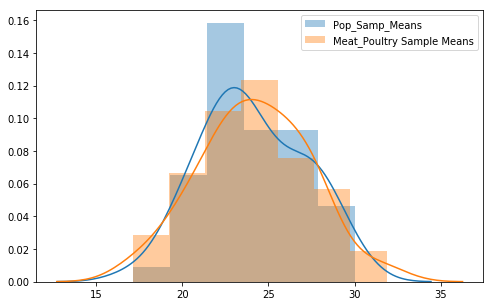

Shapiro Normality Test Test For Pop_Samp_Means
p = 0.9680752158164978
Therefore the data is normal

Shapiro Normality Test Test For Meat_Poultry
p = 0.9680752158164978
Therefore the data is normal

Levene variance test of pop_samp_means and Meat_Poultry
p = 0.7711003002641813
Therefore the data HAS equal variances

Welch T-Test of our data:
0.19202509896906458

p-value of Welch TTest
0.8481210593561013

Independent ttest scipy.stats
Ttest_indResult(statistic=-0.19202509896906458, pvalue=0.8481198783235114)

Cohen_D Of Pop_Samp_Means And Meat_Poultry
0.038794928468298136

Statistical Power of the discount given alpha=0.05, effect size:0.038794928468298136, nobs1:50
0.05423714527875878


In [24]:
from itertools import combinations

#Genreate the combinations of the different keys.
# We are only interested in the first 5, since those are the combinations of non_discount vs discount
comb = list(combinations(dict_samp_means.keys(), 2))

for (a,b) in comb[:8]:
    plt.figure(figsize=(8,5))
    
    sns.distplot(a=dict_samp_means[a], label=f'{a}') 
    sns.distplot(a=dict_samp_means[b], label=f'{b}')
    
    plt.legend([f'{a}'.title(),f'{b} Sample Means'])
    plt.show()
    
    print(f'Shapiro normality test test for {a}'.title())
    ct.normality_test_shapiro(dict_samp_means[b])

    print(f'\nShapiro normality test test for {b}'.title())
    ct.normality_test_shapiro(dict_samp_means[b])
    
    print(f'\nLevene variance test of {a} and {b}')
    is_var_equal = ct.test_equal_variances(dict_samp_means[a], dict_samp_means[b])
    
    print(f'\nWelch T-Test of our data:')
    print(fs.welch_t(dict_samp_means[a], dict_samp_means[b]))
    
    print(f'\np-value of Welch TTest')
    print(fs.p_value_welch_ttest(dict_samp_means[a], dict_samp_means[b],two_sided=True))
    
    print(f'\nIndependent ttest scipy.stats')
    print(scs.ttest_ind(dict_samp_means[a], dict_samp_means[b], equal_var=is_var_equal))
    
    print(f"\nCohen_D of {a} and {b}".title())
    effect_size = abs(fs.cohen_d(dict_samp_means[a], dict_samp_means[b]))
    print(effect_size)
    
    n= dict_samp_means[a].size
    print(f'\nStatistical Power of the discount given alpha=0.05, effect size:{effect_size}, nobs1:{n}')
    print(tt_ind_solve_power(effect_size=effect_size, nobs1=n, alpha=0.05))

# Conclusion

Based on our ANOVA test and our Tukey Test, there is not a significant impact of the category of goods on the amount of quantity of goods sold.  From this information, **we fail to reject our null hypothesis.**

Despite the different types of goods ordered at different prices, **there is not a significant statistical difference in the quantity of one category group ordered over another.**
